**Lidia Velicia Ruiz**  
NP: **144781**

# Problema de clasificación: Titanic
Usando el conocido dataset con información de los pasajeros del Titanic, comparar la precisión de los siguientes modelos de clasificación para predecir la supervivencia de los pasajeros:
1. Regresión Logística
2. Arbol de Decisión
3. Random Forest
4. Gradient Boost Tree (GBT)
5. Support Vector Machine (SVM)
6. Naive Bayes
7. Red Neuronal (Perceptrón Multicapa)


## 1.- INICIALIZACIÓN

### Pyspark
Instalamos e inicializamos pyspark

In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,036 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [825 kB]
Get:13 http://security.ubuntu.com/ubuntu 

Importamos algunas clases y funciones de librerías que neccesitaremos durante el proceso.

In [ ]:
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer
# evaluación modelos
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Iniciamos la sesión de pyspark

In [ ]:
spark=SparkSession.builder.appName('clasificacion_titanic').getOrCreate()

Montamos Drive para poder acceder a nuestro almacenamiento en la nube.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Cargar datos
Cargamos los datos desde el archivo csv que tenemos guardado en Drive.

In [ ]:
data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Program-Paralela-Distribuida/02_ML-pyspark/Entrega-2_Titanic/titanic_train.csv", sep=',', header=True, inferSchema=True)
data.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

## 2.- ANÁLISIS VARIABLES

Nos encontramos ante un dataset de 12 columnas y 891 entradas.

In [ ]:
num_filas = data.count()
print('Filas:', num_filas)
num_columnas = len(data.columns)
print('Columnas:', num_columnas)

Filas: 891
Columnas: 12


Estudiaremos cada columna en particular y veremos qué variable representa cada una, en relación al análisis que queremos hacer para predecir la supervivencia de los pasajeros.  
  
Para ello, obendremos información usando una función propia que nos da algunas estadísticas de interés de la variable:

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt
import seaborn as sns

# obtenemos el numero de valores nulos para cada variable
df_num_nulos = data.select( [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns] )


# definimos la función para obtener información de la columna
def obtener_info_columna(var):
  # tipo de datos
  tipo_dato = data.select(var).dtypes
  print(f'Tipo de dato: {tipo_dato[0][1]}')

  # valores únicos
  lista_val_uniq = data.select(var).distinct().collect()
  num_val_uniq = len(lista_val_uniq)
  print(f'Valores únicos: {num_val_uniq}')

  # valores nulos
  num_nulos = df_num_nulos.collect()[0][var]
  print(f'Valores nulos: {num_nulos}')


# VISUALIZACIÓN DATOS
# es necesario pasar el dataframe a Pandas para poder usar matplolib y seaborn
data_pd_df = data.toPandas()

def visualizar_datos_categ(var):
  # diagrama de barras
  gr = sns.countplot(x=var, data=data_pd_df)
  gr.set_title(f"Distribución de la variable '{var}'")

def visualizar_datos_num(var):
  # histograma
  gr = sns.histplot(x=var, data=data_pd_df)
  gr.set_title(f"Distribución de la variable '{var}'")



### Variables independientes
He considerado las siguientes columnas como variables características:

- ```Pclass``` (*int*) CATEGÓRICA: clase del ticket del pasajero (```1```=*1º clase*,  ```2```=*2º clase*,  ```3```=*3º clase*). Es una variable relevante para el análisis, ya que los pasajeros de clases más altas es más posible que sobrevivan.

Tipo de dato: int
Valores únicos: 3
Valores nulos: 0
+-------+------------------+
|summary|            Pclass|
+-------+------------------+
|  count|               891|
|   mean| 2.308641975308642|
| stddev|0.8360712409770491|
|    min|                 1|
|    max|                 3|
+-------+------------------+



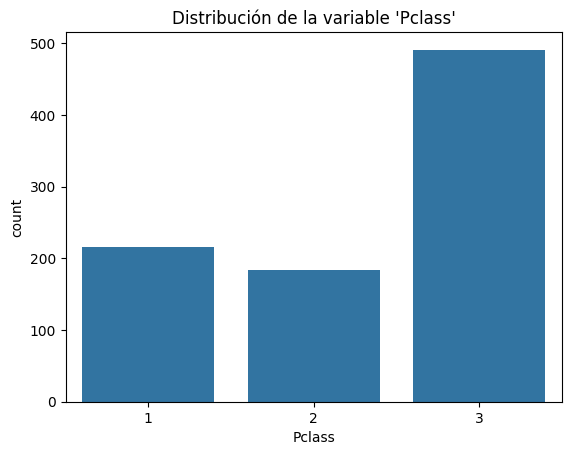

In [ ]:
obtener_info_columna('Pclass')
data.select('Pclass').describe().show()
visualizar_datos_categ('Pclass')

- ```Sex``` (*str*) CATEGÓRICA : género del pasajero. Es una variable determinante porque mujeres y niños tomaron las barcas salvavidas primero.

Tipo de dato: string
Valores únicos: 2
Valores nulos: 0


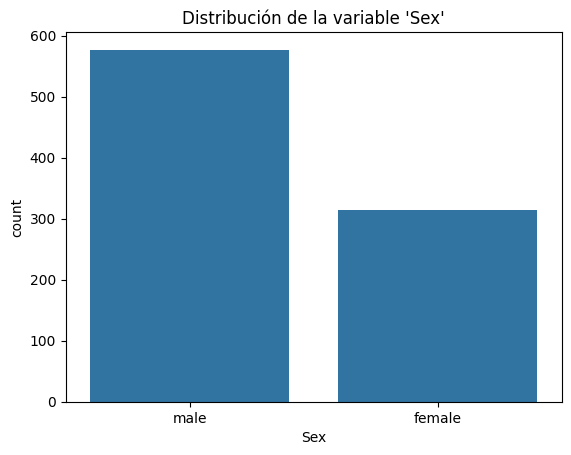

In [ ]:
obtener_info_columna('Sex')
visualizar_datos_categ('Sex')

- ```Age``` (*float*) CONTINUA : edad del pasajero. Es una variable determinante porque mujeres y niños tomaron las barcas salvavidas primero.

Tipo de dato: double
Valores únicos: 89
Valores nulos: 177
+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               714|
|   mean| 29.69911764705882|
| stddev|14.526497332334035|
|    min|              0.42|
|    max|              80.0|
+-------+------------------+



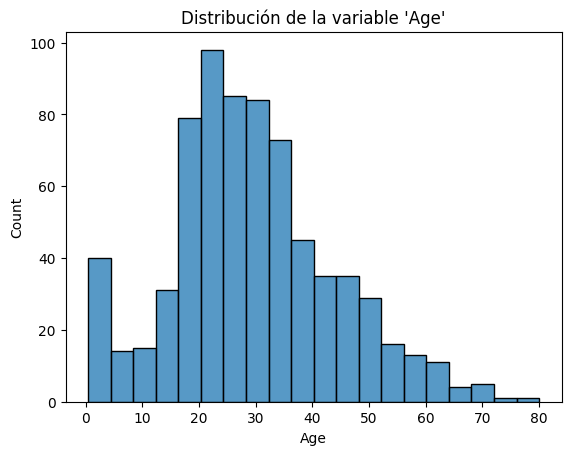

In [ ]:
obtener_info_columna('Age')
data.select('Age').describe().show()
visualizar_datos_num('Age')

En la variable ```Age``` tenemos un problema, el elevado número de valores nulos, que no podemos eliminar, porque nuestro dataset quedaría demasiado reducido.   
  
Para solucionar este problema, vamos a sustituirlos por el valor de la **Mediana** (lo haremos en el paso 3 de Preprocesamiento de Datos).

Considero que la Mediana es mejor representante de los datos que la Media para esta variable por dos razones:
-  la distribución de la variable no sigue estrictamente una distribución normal, no es simétrica. Por lo que la Media no va a ser la mejor representación de la tendencia central de los datos.
- la presencia de valores atípicos afectarían al valor de la Media, y ésta no representaría fielmente el conjunto de datos.

Text(0.5, 1.0, "Datos atípicos 'Age'")

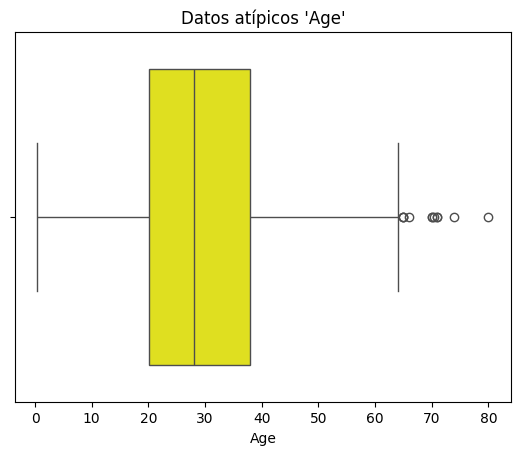

In [ ]:
gr = sns.boxplot(x='Age', data=data_pd_df, color='yellow')
gr.set_title("Datos atípicos 'Age'")

- ```SibSp``` (*int*) DISCRETA : número de parientes (cónyuge/hermanos) a bordo.

Tipo de dato: int
Valores únicos: 7
Valores nulos: 0
+-------+------------------+
|summary|             SibSp|
+-------+------------------+
|  count|               891|
|   mean|0.5230078563411896|
| stddev|1.1027434322934315|
|    min|                 0|
|    max|                 8|
+-------+------------------+



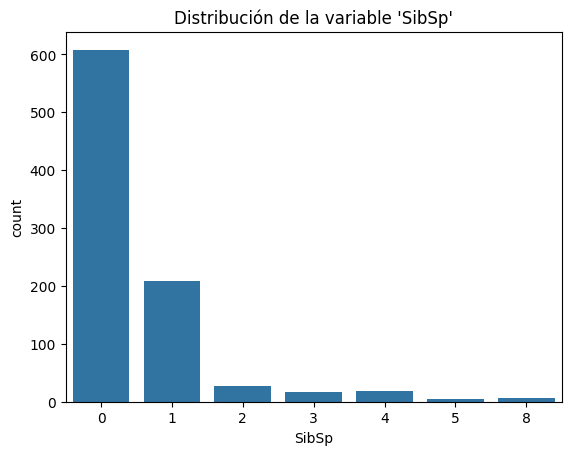

In [ ]:
obtener_info_columna('SibSp')
data.select('SibSp').describe().show()
visualizar_datos_categ('SibSp')

- ```Parch``` (*int*) DISCRETA : número de padres/hijos a bordo.

Tipo de dato: int
Valores únicos: 7
Valores nulos: 0
+-------+-------------------+
|summary|              Parch|
+-------+-------------------+
|  count|                891|
|   mean|0.38159371492704824|
| stddev| 0.8060572211299488|
|    min|                  0|
|    max|                  6|
+-------+-------------------+



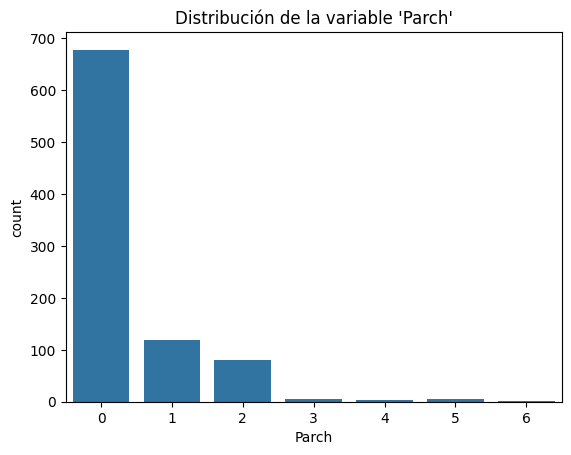

In [ ]:
obtener_info_columna('Parch')
data.select('Parch').describe().show()
visualizar_datos_categ('Parch')

Posteriormente crearemos una columna que aglutine estas dos variables: ```NumRelatives``` (número de parientes a bordo).

- ```Fare``` (*float*) CONTINUA : precio pagado por el ticket de embarque. Es también representativo de la clase social del pasajero, y por tanto, relevante para el análisis.

Tipo de dato: double
Valores únicos: 248
Valores nulos: 0
+-------+-----------------+
|summary|             Fare|
+-------+-----------------+
|  count|              891|
|   mean| 32.2042079685746|
| stddev|49.69342859718089|
|    min|              0.0|
|    max|         512.3292|
+-------+-----------------+



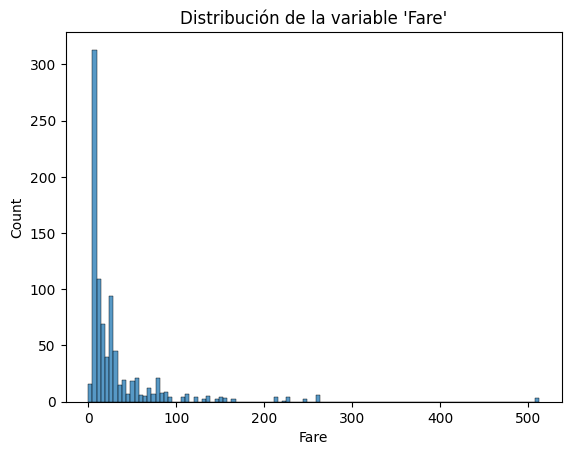

In [ ]:
obtener_info_columna('Fare')
data.select('Fare').describe().show()
visualizar_datos_num('Fare')

### Variable dependiente
La variable objetivo de nuestra clasificación es:

- ```Survived``` (*int*) CATEGORICA : si la persona sobrevivió (1) o no (0).

Tipo de dato: int
Valores únicos: 2
Valores nulos: 0
+-------+-------------------+
|summary|           Survived|
+-------+-------------------+
|  count|                891|
|   mean| 0.3838383838383838|
| stddev|0.48659245426485753|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



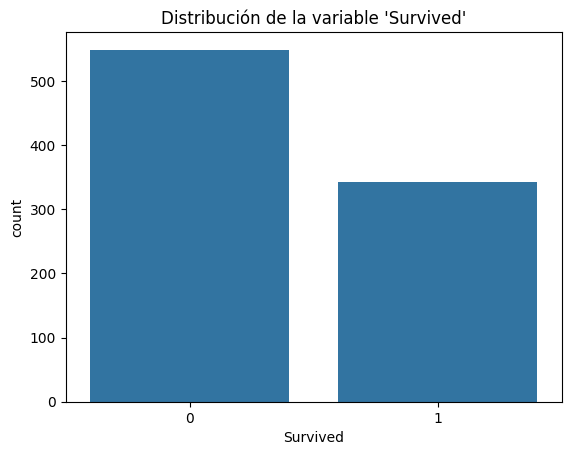

In [ ]:
obtener_info_columna('Survived')
data.select('Survived').describe().show()
visualizar_datos_categ('Survived')

### Otras columnas
Columnas que no aportan información al análisis por distintas razones:

- ```PassengerId``` (*int*) ID : identificador del pasajero, no se considera una variable, es simplemente identificativa.

In [ ]:
obtener_info_columna('PassengerId')

Tipo de dato: int
Valores únicos: 891
Valores nulos: 0


- ```Name``` (*str*) ID : nombre del pasajero, también identificativa.

In [ ]:
obtener_info_columna('Name')

Tipo de dato: string
Valores únicos: 891
Valores nulos: 0


- ```Ticket``` (*str*) ID : número de billete. Nos podría indicar personas que viajaban juntas (mismo ticket), pero este dato en sí no es relevante para el análisis, ya que no aporta información cuantitativa.

In [ ]:
obtener_info_columna('Ticket')

Tipo de dato: string
Valores únicos: 681
Valores nulos: 0


- ```Cabin``` (*str*) CUALITATIVA : número de camarote del pasajero.

In [ ]:
obtener_info_columna('Cabin')

Tipo de dato: string
Valores únicos: 148
Valores nulos: 687


Esta columna podría ser interesante, pero no nos aporta información de calidad, ya que:
1. la mayoría de los valores son nulos
2. el tipo de variable 'string' no aporta información cuantitativa.     
  
Si se tratase e interpretase correctamente, podría considerarse indicador de la clase social de los pasajeros, pero para ello ya tenemos las variables ```Pclass``` y ```Fare``` que están mucho más completas.

- ```Embarked``` (*str*) CATEGÓRICA : puerto en el que embarcó el pasajero (```C```=*Cherbourg*, ```Q```=*Queenstown*, ```S```=*Southampton*). No es información que afecte a la posibilidad de supervivencia del pasajero.

Tipo de dato: string
Valores únicos: 4
Valores nulos: 2


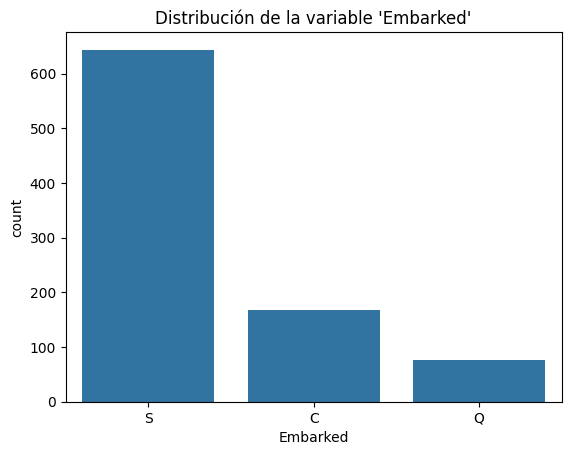

In [ ]:
obtener_info_columna('Embarked')
visualizar_datos_categ('Embarked')

### Conclusión análisis inicial
Por último, para tener una visión general, presento unas visualización de la relación entre las variables que hemos considerado como determinantes y la supervivencia de los pasajeros.

<ipython-input-21-aadf2aeb0c40>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=var, y='Survived', data=data_pd_df, ax=ax, ci=None)
<ipython-input-21-aadf2aeb0c40>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=var, y='Survived', data=data_pd_df, ax=ax, ci=None)
<ipython-input-21-aadf2aeb0c40>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=var, y='Survived', data=data_pd_df, ax=ax, ci=None)
<ipython-input-21-aadf2aeb0c40>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=var, y='Survived', data=data_pd_df, ax=ax, ci=None)


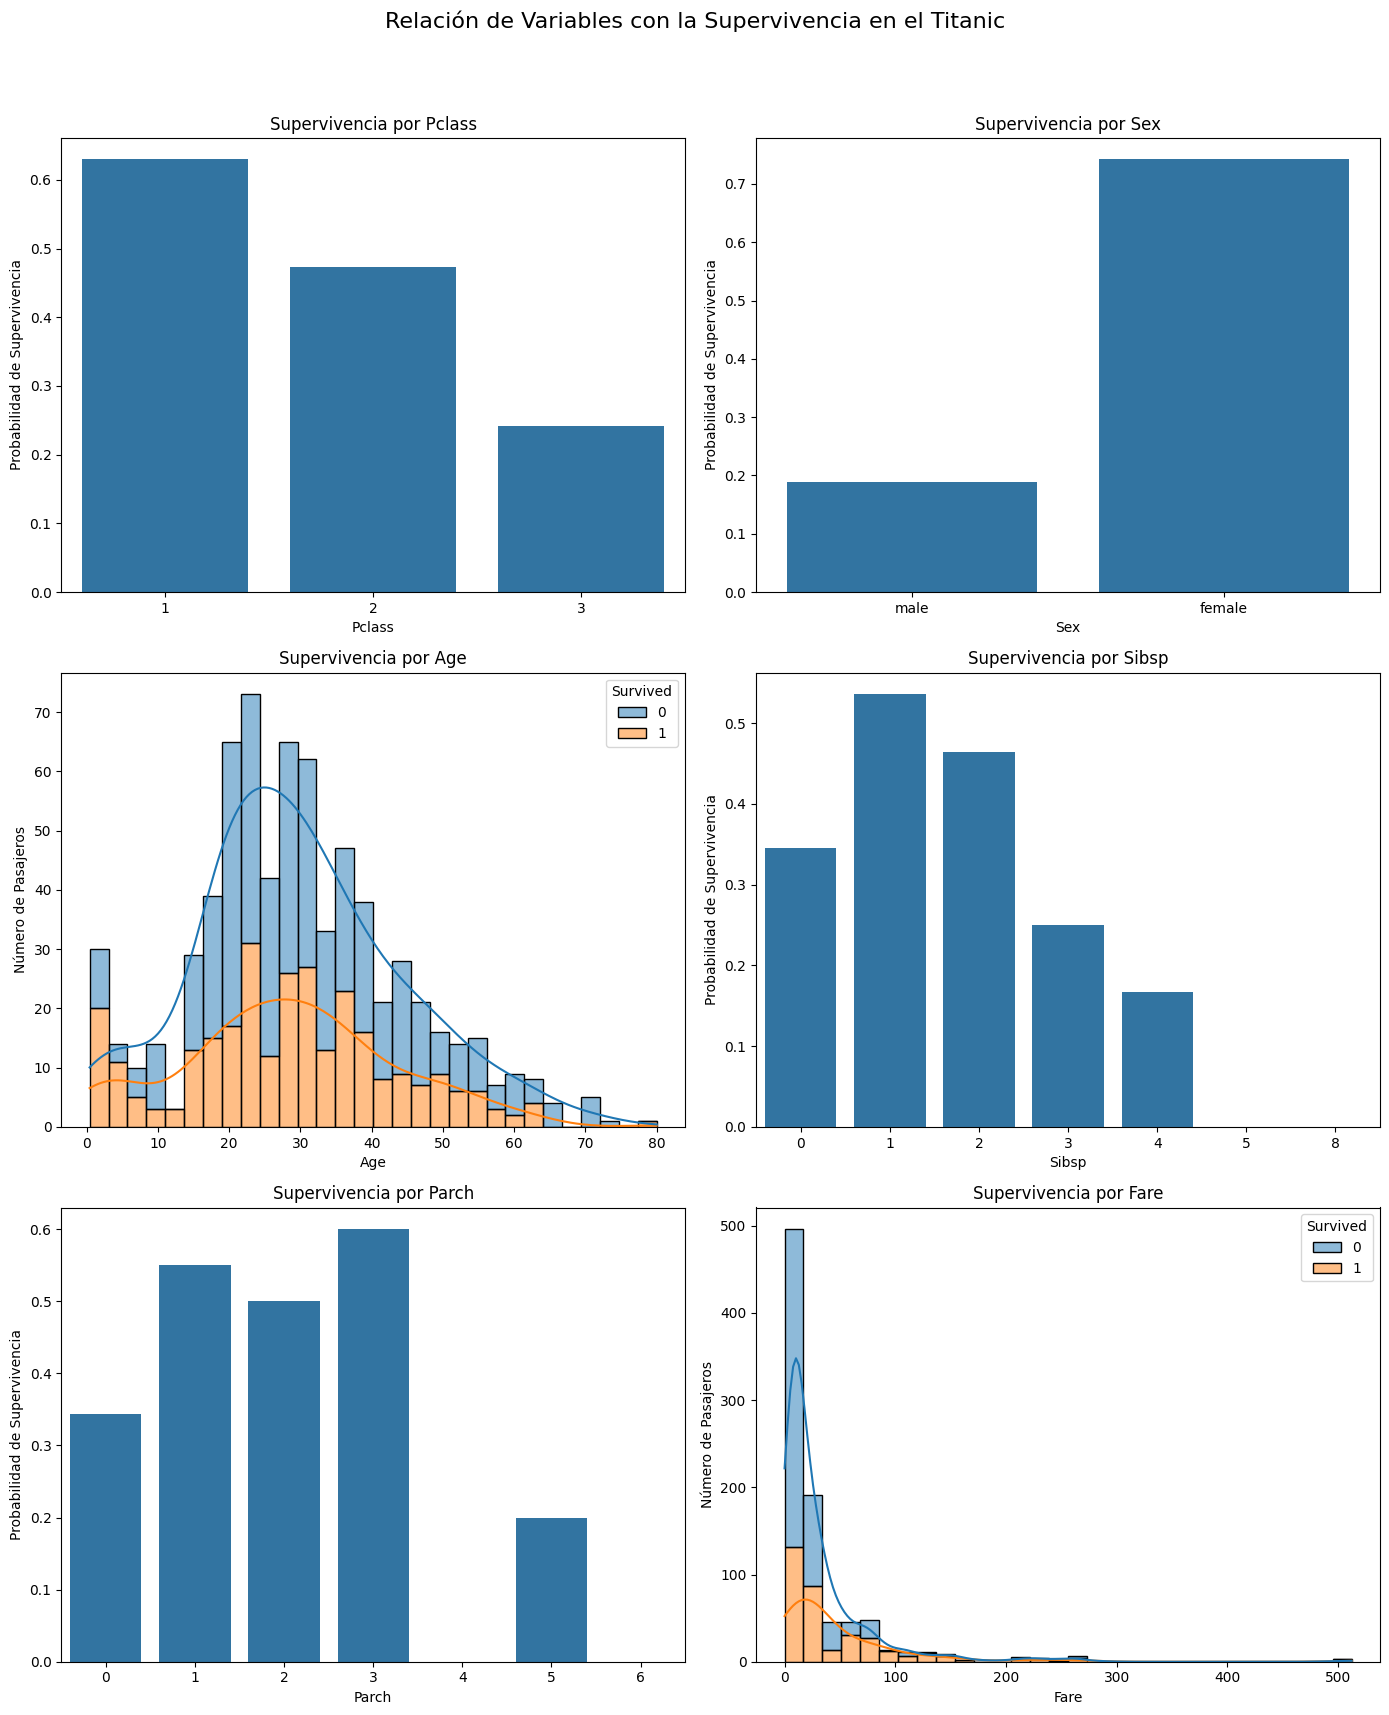

In [ ]:
# Área de subgráficos
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
fig.suptitle('Relación de Variables con la Supervivencia en el Titanic', fontsize=16)

# Variables a representar
variables = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']

# Función para crear gráficos de barras para variables categóricas
def categorical_plot(var, ax):
    sns.barplot(x=var, y='Survived', data=data_pd_df, ax=ax, ci=None)
    ax.set_title(f'Supervivencia por {var.capitalize()}')
    ax.set_ylabel('Probabilidad de Supervivencia')
    ax.set_xlabel(var.capitalize())

# Función para crear histogramas para variables numéricas
def numerical_plot(var, ax):
    sns.histplot(data=data_pd_df, x=var, hue='Survived', multiple='stack', ax=ax, bins=30, kde=True)
    ax.set_title(f'Supervivencia por {var.capitalize()}')
    ax.set_ylabel('Número de Pasajeros')
    ax.set_xlabel(var.capitalize())


# Graficar
for i, var in enumerate(variables):
    if var in ['Pclass', 'Sex', 'SibSp', 'Parch']:
        categorical_plot(var, axes[i // 2, i % 2])
    else:
        numerical_plot(var, axes[i // 2, i % 2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 3-. PREPROCESAMIENTO DE DATOS

Creamos una copia de los datos, para realizar modificaciones el el dataframe sin que peligren los datos originales.

In [ ]:
df_3_0 = data.alias('df_1')

### 3.1.- Crear variable conjunta ```NumRelatives```

```NumRelatives``` (número de parientes de a bordo de un pasajero) que combina las variables ```SibSp``` y ```Parch```.

In [ ]:
df_3_1 = df_3_0.withColumn("NumRelatives", col("SibSp")+col("Parch"))
df_3_1.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|NumRelatives|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+------------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|           1|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|           1|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|           0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|           1|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL

### 3.2.- Eliminar columnas innecesarias
Eliminaremos las columnas "otros" que no aportan información al análisis y las variables ```SibSp```, ```Parch```, que ya se tienen en cuenta en la variable conjunta ```NumRelatives```.

In [ ]:
cols_elim = ["PassengerId","Name","Ticket","Cabin","Embarked","SibSp","Parch"]

df_3_2 = df_3_1.drop(*cols_elim)
df_3_2.show(10)

+--------+------+------+----+-------+------------+
|Survived|Pclass|   Sex| Age|   Fare|NumRelatives|
+--------+------+------+----+-------+------------+
|       0|     3|  male|22.0|   7.25|           1|
|       1|     1|female|38.0|71.2833|           1|
|       1|     3|female|26.0|  7.925|           0|
|       1|     1|female|35.0|   53.1|           1|
|       0|     3|  male|35.0|   8.05|           0|
|       0|     3|  male|NULL| 8.4583|           0|
|       0|     1|  male|54.0|51.8625|           0|
|       0|     3|  male| 2.0| 21.075|           4|
|       1|     3|female|27.0|11.1333|           2|
|       1|     2|female|14.0|30.0708|           1|
+--------+------+------+----+-------+------------+
only showing top 10 rows



### 3.3.- Tratamiento de nulos en variable ```Age```
Sustituimos los valores nulos por la mediana (valor en el percentil 50) de la variable ```Age```.

In [ ]:
edad_mediana = df_3_2.agg({'Age':'median'}).first()[0]
df_3_3 = df_3_2.fillna(edad_mediana)
df_3_3.show(10)

+--------+------+------+----+-------+------------+
|Survived|Pclass|   Sex| Age|   Fare|NumRelatives|
+--------+------+------+----+-------+------------+
|       0|     3|  male|22.0|   7.25|           1|
|       1|     1|female|38.0|71.2833|           1|
|       1|     3|female|26.0|  7.925|           0|
|       1|     1|female|35.0|   53.1|           1|
|       0|     3|  male|35.0|   8.05|           0|
|       0|     3|  male|28.0| 8.4583|           0|
|       0|     1|  male|54.0|51.8625|           0|
|       0|     3|  male| 2.0| 21.075|           4|
|       1|     3|female|27.0|11.1333|           2|
|       1|     2|female|14.0|30.0708|           1|
+--------+------+------+----+-------+------------+
only showing top 10 rows



Comprobamos que, en efecto, ya no tenemos ningún valor nulo.

In [ ]:
df_num_nulos = df_3_3.select( [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_3_3.columns] )
df_num_nulos.show()

+--------+------+---+---+----+------------+
|Survived|Pclass|Sex|Age|Fare|NumRelatives|
+--------+------+---+---+----+------------+
|       0|     0|  0|  0|   0|           0|
+--------+------+---+---+----+------------+



### 3.4.- Indexar variable categórica ```Sex```
La transformamos a formato numérico
- ```0 ```= ```'male'```
- ```1``` = ```'female'```  
  
para que los modelos puedan usarla en la predicción de la variable objetivo.

In [ ]:
# indexamos usando Pipeline
indexer = [StringIndexer(inputCol="Sex", outputCol="Sex_IND")]
pipeline_index = Pipeline(stages=indexer)
df_3_4 = pipeline_index.fit(df_3_3).transform(df_3_3)
df_3_4.show(5)

+--------+------+------+----+-------+------------+-------+
|Survived|Pclass|   Sex| Age|   Fare|NumRelatives|Sex_IND|
+--------+------+------+----+-------+------------+-------+
|       0|     3|  male|22.0|   7.25|           1|    0.0|
|       1|     1|female|38.0|71.2833|           1|    1.0|
|       1|     3|female|26.0|  7.925|           0|    1.0|
|       1|     1|female|35.0|   53.1|           1|    1.0|
|       0|     3|  male|35.0|   8.05|           0|    0.0|
+--------+------+------+----+-------+------------+-------+
only showing top 5 rows



Quitamos la variable 'Sex' no indexada que ya no la necesitamos

In [ ]:
df_3_4 = df_3_4.drop('Sex')
df_3_4.show(5)

+--------+------+----+-------+------------+-------+
|Survived|Pclass| Age|   Fare|NumRelatives|Sex_IND|
+--------+------+----+-------+------------+-------+
|       0|     3|22.0|   7.25|           1|    0.0|
|       1|     1|38.0|71.2833|           1|    1.0|
|       1|     3|26.0|  7.925|           0|    1.0|
|       1|     1|35.0|   53.1|           1|    1.0|
|       0|     3|35.0|   8.05|           0|    0.0|
+--------+------+----+-------+------------+-------+
only showing top 5 rows



### 3.5.- Vectorizar y Escalar las Var. Independientes
Vectorizamos las variables para el entrenamiento de los modelos. Posteriormente, las escalamos usando el método ```MinMaxScaler()``` que trasnforma las características al rango [0,1], conservando su distribución original.  
Integramos estas dos acciones secuencialmente usando un Pipeline.

In [ ]:
var_indep = ["Pclass","Age","Fare","NumRelatives","Sex_IND"]

# ensamblado
assembler = VectorAssembler(inputCols=var_indep,
                            outputCol="var_indep")
# escalardo
scaler = MinMaxScaler(inputCol='var_indep', outputCol='var_indep_SC')

# PIPELINE
pipeline_sc = Pipeline(stages=[assembler, scaler])
model = pipeline_sc.fit(df_3_4)
df_3_5 = model.transform(df_3_4)
df_3_5.show(5)

+--------+------+----+-------+------------+-------+--------------------+--------------------+
|Survived|Pclass| Age|   Fare|NumRelatives|Sex_IND|           var_indep|        var_indep_SC|
+--------+------+----+-------+------------+-------+--------------------+--------------------+
|       0|     3|22.0|   7.25|           1|    0.0|[3.0,22.0,7.25,1....|[1.0,0.2711736617...|
|       1|     1|38.0|71.2833|           1|    1.0|[1.0,38.0,71.2833...|[0.0,0.4722292033...|
|       1|     3|26.0|  7.925|           0|    1.0|[3.0,26.0,7.925,0...|[1.0,0.3214375471...|
|       1|     1|35.0|   53.1|           1|    1.0|[1.0,35.0,53.1,1....|[0.0,0.4345312892...|
|       0|     3|35.0|   8.05|           0|    0.0|[3.0,35.0,8.05,0....|[1.0,0.4345312892...|
+--------+------+----+-------+------------+-------+--------------------+--------------------+
only showing top 5 rows



### 3.6.- Separar datos de entrenamiento y test
- Los datos de entrenamiento ```data_train``` (80%): se usarán para entrenar cada uno de los modelos.

- Los datos de test ```data_train``` (20%): se usarán tras entrenar cada modelo en la evaluación del mismo, para comprobar cómo de bien clasifica la variable objetivo.  
  
Impondremos una ```seed=42``` para que la división de datos tenga cierta aleatoriedad.

In [ ]:
data_train, data_test = df_3_5.randomSplit([0.8, 0.2], seed=42)

## 4.- ENTRENAMIENTO Y EVALUACIÓN DE MODELOS DE CLASIFICACIÓN
Entrenaremos y evaluaremos los siguientes modelos de clasificación:
1. Regresión Logística
2. Arbol de Decisión
3. Random Forest
4. Gradient Boost Tree (GBT)
5. Support Vector Machine (SVM)
6. Naive Bayes
7. Red Neuronal (Perceptrón Multicapa)

Para no tener que escribir el código cada vez, vamos a crear una función que, metiendo como parámetro la instancia al modelo de ML que queramos usar:
1. lo entrena con los datos de entrenamiento
2. usa el modelo entrenado para realizar la predicción de supervivencia con los datos de test
3. evalúa dicha predicción, basándose en la métrica **precisión**
4. devuelve una tupla con el Dataframe resultante de la predicción y el valor de precisión calculado

In [ ]:
def entrenar_evaluar_modelo(modelo_ML):
  '''Función que entrena y evalúa un modelo
  PARAM:
  <- modelo_ML: instancia a la clase del modelo que queramos usar

  RETURN:
  -> (df_prediccion, precision) -tupla:
    * df_prediccion: dataframe con la predicción realizada por el modelo
    * precision: valor de precisión de la evaluación del modelo
  '''

  # ENTRENAMIENTO
  modelo_entr = modelo_ML.fit(data_train)

  # EVALUACIÓN
  df_prediccion = modelo_entr.transform(data_test)

  evaluator = MulticlassClassificationEvaluator(labelCol="Survived",
                                                predictionCol="prediction",
                                                metricName="accuracy")
  precision = evaluator.evaluate(df_prediccion)

  return df_prediccion, precision

### 4.1.- Regresión Logística

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Modelo
RegrLog = LogisticRegression(featuresCol="var_indep_SC",
                             labelCol="Survived")

df_pred_RegrLog, prec_RegrLog = entrenar_evaluar_modelo(RegrLog)
print('Precisión:', prec_RegrLog)

Precisión: 0.7931034482758621


### 4.2.- Árbol de Decisión

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Modelo
ArbolClasif = DecisionTreeClassifier(featuresCol="var_indep_SC",
                                     labelCol="Survived")

df_pred_ArbolClasif, prec_ArbolClasif = entrenar_evaluar_modelo(ArbolClasif)
print('Precisión:', prec_ArbolClasif)

Precisión: 0.7862068965517242


### 4.3.- Random Forest
```numTrees``` : número de árboles de decisión que entrena dentro del modelo.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Modelo
RandForest = RandomForestClassifier(featuresCol="var_indep_SC",
                                    labelCol="Survived",
                                    numTrees=10)
#seed=53 --> 12
#seed=42 --> 10

df_pred_RandForest, prec_RandForest = entrenar_evaluar_modelo(RandForest)
print('Precisión:', prec_RandForest)

Precisión: 0.7931034482758621


### 4.4.- Gradient Boost Tree
```maxIter``` : máximo número de árboles que se contruyen en el entrenamiento del modelo.

In [ ]:
from pyspark.ml.classification import GBTClassifier

# Modelo
GBT = GBTClassifier(featuresCol="var_indep_SC",
                    labelCol="Survived",
                    maxIter=10)

df_pred_GBT, prec_GBT = entrenar_evaluar_modelo(GBT)
print('Precisión:', prec_GBT)

Precisión: 0.7862068965517242


### 4.5.- SVM
```maxIter=10``` : número máximo de iteraciones que el algoritmo ejecuta durante el entrenamiento.

In [ ]:
from pyspark.ml.classification import LinearSVC

# Modelo
SVM = LinearSVC(featuresCol="var_indep_SC",
                labelCol="Survived",
                maxIter=10)

df_pred_SVM, prec_SVM = entrenar_evaluar_modelo(SVM)
print('Precisión:', prec_SVM)


Precisión: 0.7586206896551724


### 4.6.- Naive Bayes
```modelType=multinomial``` : el modelo usa la distribución de probabilidad multinomial.

In [ ]:
from pyspark.ml.classification import NaiveBayes

# Modelo
Bayes = NaiveBayes(modelType="multinomial",
                   featuresCol="var_indep_SC",
                   labelCol="Survived")

df_pred_Bayes, prec_Bayes = entrenar_evaluar_modelo(Bayes)
print('Precisión:', prec_Bayes)

Precisión: 0.7586206896551724


### 4.7.- Red Neuronal (Perceptrón Multicapa)
Entrenaremos una red con 1 capa oculta:
- ```layers=[5,16,2]``` : capa inicial de 5 neuronas (las variables independientes), capa oculta de 16, y capa de salida de 2 (valores que puede tomar la variable dependiente).
- ```maxIter=1000``` : número de epochs (iteraciones) de la red
- ```blockSize=8``` : tamaño del bloque de datos para apilar datos en la red
- ```seed=7``` : factor de aleatoriedad de selección de datos
- ```solver='gd'``` : algoritmo de optimización, en este caso usamos el Descenso de Gradiente.

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Modelo
MLPC = MultilayerPerceptronClassifier( featuresCol="var_indep_SC",
                                            labelCol="Survived",
                                            layers = [len(var_indep),16,2],
            # la variable dependiente toma 2 posibles valores (0,1)
                                            maxIter=1000,
                                            blockSize=8,
                                            seed=7,
                                            solver="gd")

df_pred_MLPC, prec_MLPC = entrenar_evaluar_modelo(MLPC)
print('Precisión:', prec_MLPC)


Precisión: 0.7724137931034483


## Conclusión

Creamos un dataframe con el valor de precisión obtenido para cada modelo:

In [ ]:
from pyspark.sql import Row

resultados = [
    Row(Modelo="Regresión Logística", Precisión=prec_RegrLog),
    Row(Modelo="Árbol de Decisión", Precisión=prec_ArbolClasif),
    Row(Modelo="Random Forest", Precisión=prec_RandForest),
    Row(Modelo="GBT", Precisión=prec_GBT),
    Row(Modelo="SVM", Precisión=prec_SVM),
    Row(Modelo="Bayes", Precisión=prec_Bayes),
    Row(Modelo="Red Neuronal (MLPC)", Precisión=prec_MLPC),
]

df_resultados = spark.createDataFrame(resultados)

df_resultados.orderBy(col("Precisión").desc()).show()


+-------------------+------------------+
|             Modelo|         Precisión|
+-------------------+------------------+
|Regresión Logística|0.7931034482758621|
|      Random Forest|0.7931034482758621|
|                GBT|0.7862068965517242|
|  Árbol de Decisión|0.7862068965517242|
|Red Neuronal (MLPC)|0.7724137931034483|
|                SVM|0.7586206896551724|
|              Bayes|0.7586206896551724|
+-------------------+------------------+



Repecto al depempeño de los modelos, cabe destacar que la Regresión Logística, modelo que asume relaciones lineales, nos da una precisión igualmente buena en comparación con modelos que capturan complejidades adicionales. Esto sugiere que muchas de las relaciones entre las variables independientes y la supervivencia pueden ser aproximadas con enfoques lineales.   
  
Por otro lado, modelos como el Random Forest, Decision Tree, GBT, Perceptrón Multicapa, que son capaces de modelar interacciones más complejas y no lineales, también tienen una precisión similar. Esto implica que hay elementos no lineales e interacciones entre variables que estos modelos están aprovechando.

Es por esto, que hay que remarcar la importancia del uso de varios modelos para capturar los distintos tipos de dinámicas de nuestro dataset.

Llama la atención que la red neuronal no sea la más precisa, al ser el modelo más complejo que mejor capta relaciones no lineales. Sin embargo, hay que recordar que este modelo es más apropiado para datasets mucho más grandes, y es posible que por eso los resultados no sean los mejores. Además, un ajuste óptimo de los parámetros de la red podría mejorar la precisión.